<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data (100k DataPoints)</h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
import tqdm
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from prettytable import PrettyTable
import path
from tqdm import tqdm
from os import path
import datetime
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

<h2> 2.3 Train and Test Construction (70:30)</h2>

In [31]:
df=pd.read_csv('train.csv')
df=df[:100000]
y=df['is_duplicate'].values
df.drop(labels=['is_duplicate'],axis=1,inplace=True)
X=df

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3)
pt=PrettyTable()
pt.field_names=["dtype","size of data"]
pt.add_row(["train",X_train.shape])
pt.add_row(["test",X_test.shape])
print(pt)

+-------+--------------+
| dtype | size of data |
+-------+--------------+
| train |  (70000, 5)  |
|  test |  (30000, 5)  |
+-------+--------------+


<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis On train Data</h1>

<h2> 3.1 Reading data and Removing Null values </h2>

<h3>3.1.1 Reading Data From Train Data</h3>

In [33]:
print("Number of data points:",X_train.shape[0])

Number of data points: 70000


In [34]:
X_train.head()

,id,qid1,qid2,question1,question2
222,222,445,446,How can I find job in Japan?,How can I find an IT job in Japan?
49405,49405,87932,7110,"Should India ban ""Made In China"" products?",Should India ban all Chinese goods or anything...
10340,10340,20044,20045,Would you date a girl that dated your best fri...,"If you are a girl, how many of you will date y..."
34683,34683,29977,7496,What are the best romance movies?,Which is the best romantic movie?
4468,4468,8830,8831,What are the best way to learn Oracle HRMS mod...,What is the Best way to learn Oracle HRMS?


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 222 to 86482
Data columns (total 5 columns):
id           70000 non-null int64
qid1         70000 non-null int64
qid2         70000 non-null int64
question1    70000 non-null object
question2    70000 non-null object
dtypes: int64(3), object(2)
memory usage: 3.2+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3>3.1.2 Handling null values with blank  </h3>

In [36]:
#Checking whether there are any rows with null values
def null_value_replacement(df):
    nan_rows = df[df.isnull().any(1)]
    print (nan_rows)
    print("\nAFTER removing null values")
    # Filling the null values with ' '
    df = df.fillna('')
    nan_rows = df[df.isnull().any(1)]
    print (nan_rows)
    return df

In [37]:
X_train=null_value_replacement(X_train)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2]
Index: []

AFTER removing null values
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2]
Index: []


<h2>3.2 EDA for X_train</h2>

In [38]:
#using X_tr_eda as a part of our exploratory data analysis
X_tr_eda=X_train.copy()
X_tr_eda['is_duplicate']=y_train

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

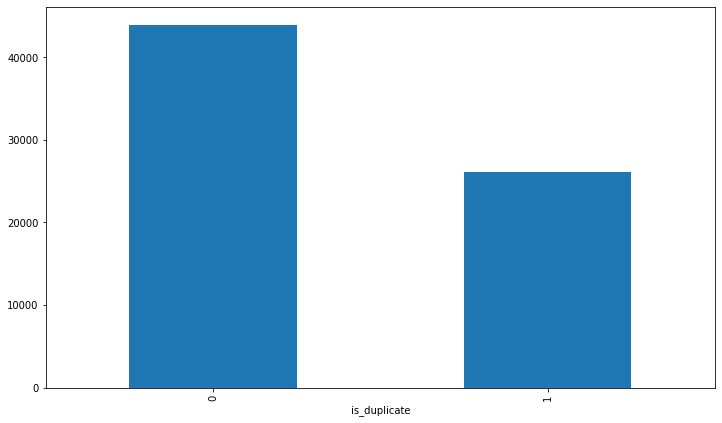

In [39]:
plt.figure(figsize=(12,7))
X_tr_eda.groupby("is_duplicate")['id'].count().plot.bar()

In [40]:
print('~> Total number of question pairs for training:\n   {}'.format(len(X_train)))

~> Total number of question pairs for training:
   70000


In [41]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'\
                  .format(100 - round(X_tr_eda['is_duplicate'].mean()*100, 2)))

print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'\
              .format(round(X_tr_eda['is_duplicate'].mean()*100, 2)))




~> Question pairs are not Similar (is_duplicate = 0):
   62.75%

~> Question pairs are Similar (is_duplicate = 1):
   37.25%


<h3> 3.2.2 Number of unique questions in train data </h3>

In [42]:
qids = pd.Series(X_train['qid1'].tolist() + X_train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.\
         format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 120819

Number of unique questions that appear more than one time: 11936 (9.879240847879887%)

Max number of times a single question is repeated: 27



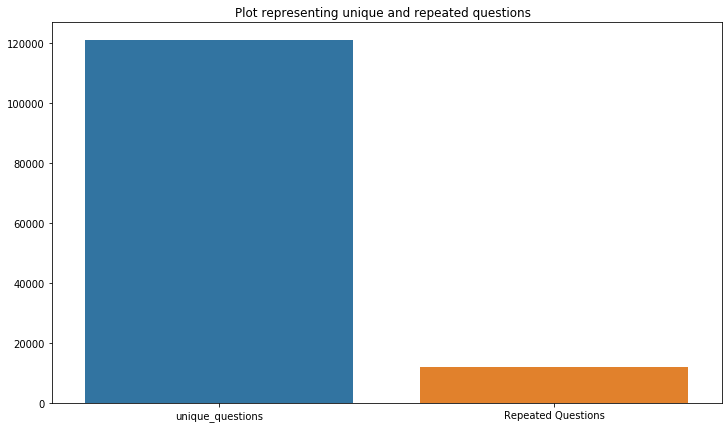

In [43]:
x1 = ["unique_questions" , "Repeated Questions"]
y1 =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(12, 7))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x1,y1)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [44]:
#checking whether there are any repeated pair of questions

pair_duplicates = X_tr_eda[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - X_tr_eda.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question in train</h3>

Maximum number of times a single question is repeated: 27



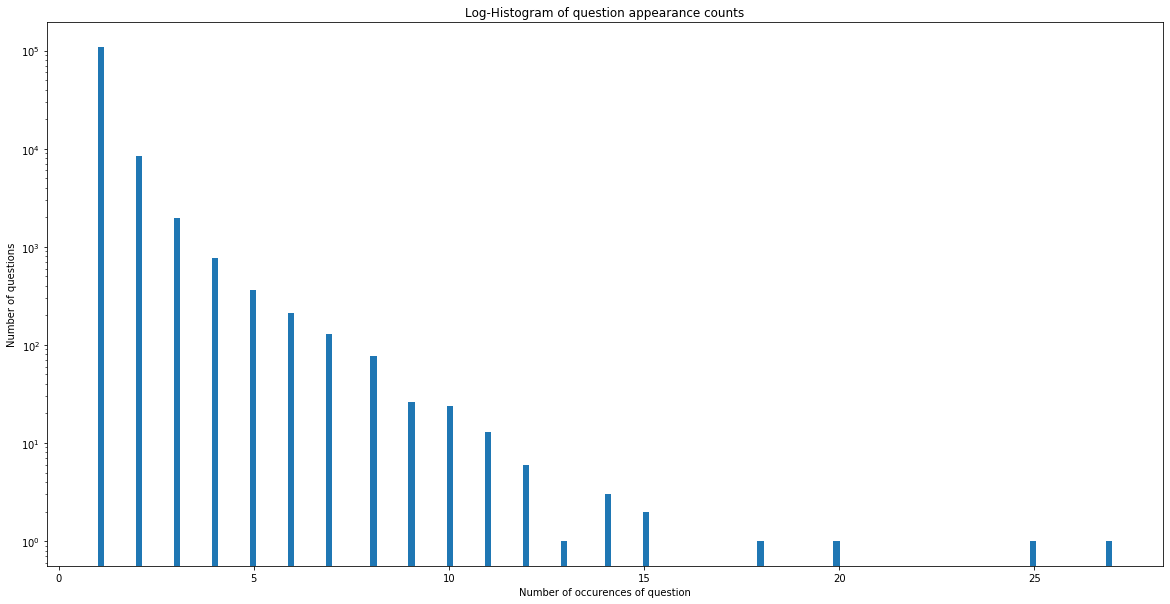

In [45]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h2>3.3 Basic Feature Extraction  (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [46]:
#As we will need our train data in advance featurizations too so it is better if we made a copy of train data\
#for each basic featurization and advance featurization

#used for basic featurization
train_bsft=X_train.copy()
#used for advance featurization
train_advft=X_train.copy()
#used for word2 vec of question1 +question2
train_wordvec_q=X_train.copy()


In [47]:
#CREATING A FUNCTION THAT WILL DO BASIC FEATURIZATIONS ON TRAIN AND TEST DATA SEPARATELY and stores it to the
#default directory:

def add_basic_feature(df1,which_data):
    df1['freq_qid1'] = df1.groupby('qid1')['qid1'].transform('count') 
    df1['freq_qid2'] = df1.groupby('qid2')['qid2'].transform('count')
    df1['q1len'] = df1['question1'].str.len() 
    df1['q2len'] = df1['question2'].str.len()
    df1['q1_n_words'] = df1['question1'].apply(lambda row: len(row.split(" ")))
    df1['q2_n_words'] = df1['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
   
    
    df1['word_Common'] = df1.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
    df1['word_Total'] = df1.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    
    df1['word_share'] = df1.apply(normalized_word_share, axis=1)

    df1['freq_q1+q2'] = df1['freq_qid1']+df1['freq_qid2']
    df1['freq_q1-q2'] = abs(df1['freq_qid1']-df1['freq_qid2'])
    
    df1.drop(labels=['id','qid1','qid2','question1','question2'],axis=1,inplace=True)
    
    #saving the extracted basic features to csv file
    if which_data=='test':
       
        df1.to_csv("X_test_with_basic_features.csv", index=False)
    if which_data=='train':
        
        df1.to_csv("X_train_with_basic_features.csv",index=False)

    print("the basic features dataframe now consists of columns {}".format(df1.columns))   

<h5>Creating basic features for train </h5>

In [48]:
print("For Train data After Basic Featurization")
add_basic_feature(train_bsft,"train")

For Train data After Basic Featurization
the basic features dataframe now consists of columns Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')


<h3> 3.3.1 Analysis of some of the basic extracted features On Train Data</h3>

In [49]:
#getting from the saved location
X_train_with_basic_features=pd.read_csv("X_train_with_basic_features.csv")
X_train_with_basic_features_eda=X_train_with_basic_features.copy()

#adding label to do EDA with class label
X_train_with_basic_features_eda["is_duplicate"]=y_train

- Here are some questions have only one single words.

In [50]:
print ("Minimum length of the questions in question1 : " , min(X_train_with_basic_features['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_train_with_basic_features['q2_n_words']))

print ("Number of Questions with minimum length [question1] :",\
           X_train_with_basic_features[X_train_with_basic_features['q1_n_words']== 1].shape[0])

print ("Number of Questions with minimum length [question2] :",\
       X_train_with_basic_features[X_train_with_basic_features['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 11
Number of Questions with minimum length [question2] : 3


<h4> 3.3.1.1 Feature: word_share </h4>

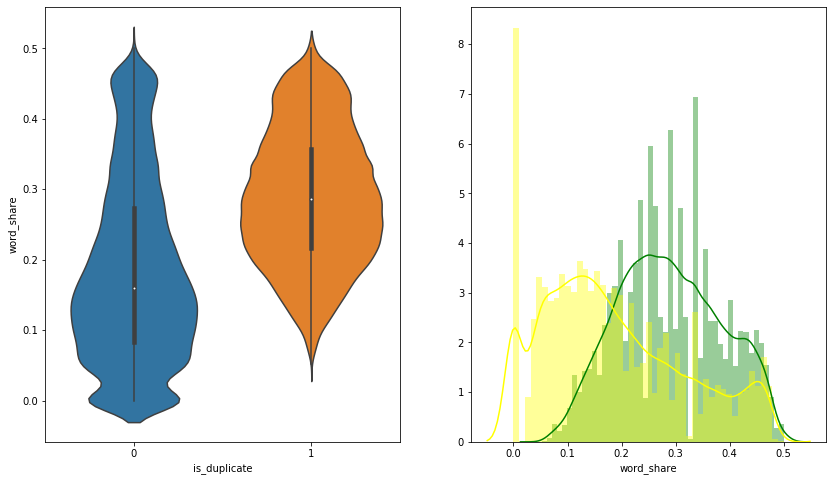

In [51]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train_with_basic_features_eda[0:])

plt.subplot(1,2,2)
sns.distplot(X_train_with_basic_features_eda[X_train_with_basic_features_eda['is_duplicate'] == 1.0]['word_share'][0:] ,\
                             label = "1", color = 'green')
sns.distplot(X_train_with_basic_features_eda[X_train_with_basic_features_eda['is_duplicate'] == 0.0]['word_share'][0:] ,\
             label = "0" , color = 'yellow' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

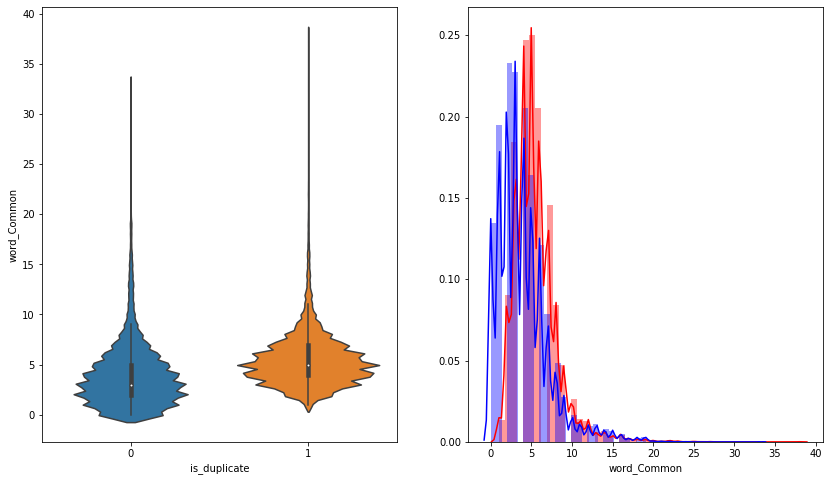

In [52]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = X_train_with_basic_features_eda[0:])

plt.subplot(1,2,2)
sns.distplot(X_train_with_basic_features_eda[X_train_with_basic_features_eda['is_duplicate'] == 1.0]['word_Common'][0:] ,\
                     label = "1", color = 'red')
sns.distplot(X_train_with_basic_features_eda[X_train_with_basic_features_eda['is_duplicate'] == 0.0]['word_Common'][0:] ,\
             label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2> 3.4 Preprocessing of Text </h2>

In [53]:
import re
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [54]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

In [55]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    #to remove html tags
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [56]:
#this function returns the first 10 token features  in a form of list
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

######################################################################################################################

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [57]:
#this function do preprocessing and advance feaurizations
def extract_features(df1,which_data):
    
    # preprocessing each question
    df1["question1"] = df1["question1"].fillna("").apply(preprocess)
    df1["question2"] = df1["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df1.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    
    df1["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df1["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df1["csc_min"]       = list(map(lambda x: x[2], token_features))
    df1["csc_max"]       = list(map(lambda x: x[3], token_features))
    df1["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df1["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df1["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df1["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df1["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df1["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df1["token_set_ratio"]       = df1.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df1["token_sort_ratio"]      = df1.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df1["fuzz_ratio"]            = df1.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df1["fuzz_partial_ratio"]    = df1.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df1["longest_substr_ratio"]  = df1.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    #saving our extracted features 
    df1.drop(labels=['id','qid1','qid2','question1','question2'],axis=1,inplace=True)
    
    if which_data=='train':
        
        df1.to_csv("X_train_with_adv_features.csv", index=False)
     
    if which_data=='test':
        
        df1.to_csv("X_test_with_adv_features.csv", index=False)
    

In [58]:
print(datetime.datetime.now())
extract_features(train_advft,"train")
print(datetime.datetime.now())

2019-08-22 14:33:46.240426
token features...
fuzzy features..
2019-08-22 14:36:16.030282


<h3>3.5.1 Analysis of extracted features </h3>

In [59]:
X_train_with_adv_features=pd.read_csv("X_train_with_adv_features.csv")
X_train_with_adv_features_eda=X_train_with_adv_features.copy()

X_train_with_adv_features_eda['is_duplicate']=y_train

X_train_with_adv_features_eda.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,is_duplicate
0,0.999967,0.999967,0.999975,0.666656,0.999986,0.777769,1.0,1.0,2.0,8.0,100,90,90,79,0.517241,0
1,0.799984,0.571420,0.999950,0.333328,0.857131,0.461535,0.0,1.0,6.0,10.0,87,59,56,67,0.395349,1


<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [60]:
df_duplicate = X_tr_eda[X_tr_eda['is_duplicate'] == 1]
dfp_nonduplicate = X_tr_eda[X_tr_eda['is_duplicate'] == 0]

w_duplicate=df_duplicate['question1'].tolist()+df_duplicate['question2'].tolist()
w_nonduplicate=dfp_nonduplicate['question1'].tolist()+dfp_nonduplicate['question2'].tolist()


print ("Number of questions in class 1 (duplicate pairs) :",len(w_duplicate))
print ("Number of dquestions in class 0 (non duplicate pairs) :",len(w_nonduplicate))

#Saving the np array into a text file
np.savetxt('w_dupli.txt',w_duplicate,fmt="%s")
np.savetxt('w_nondupli.txt',w_nonduplicate,fmt="%s")

Number of questions in class 1 (duplicate pairs) : 52156
Number of dquestions in class 0 (non duplicate pairs) : 87844


In [61]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')
w_duplicate = open(path.join(d, 'w_dupli.txt')).read()
w_nonduplicate = open(path.join(d, 'w_nondupli.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
#stopwords.remove("not")

#stopwords.remove("no")
#stopwords.remove("good")
stopwords.add("love")
stopwords.add("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(w_duplicate))
print ("Total number of words in non duplicate pair questions :",len(w_nonduplicate))

Total number of words in duplicate pair questions : 2809840
Total number of words in non duplicate pair questions : 5687352


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


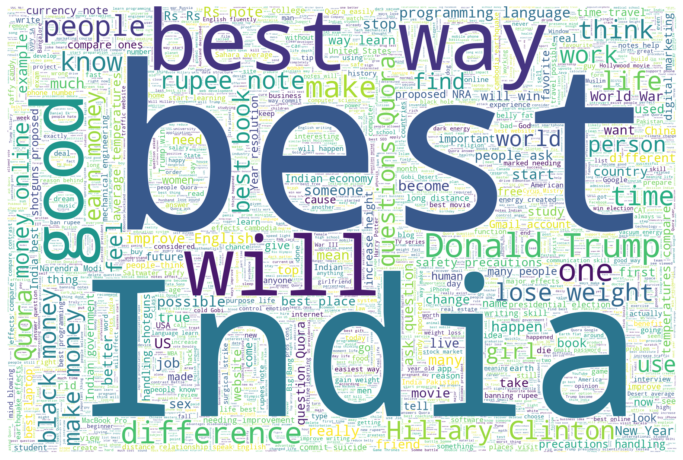

In [62]:
wc = WordCloud(background_color="white",width=1800,height=1200 ,max_words=len(w_duplicate), stopwords=stopwords)
wc.generate(w_duplicate)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


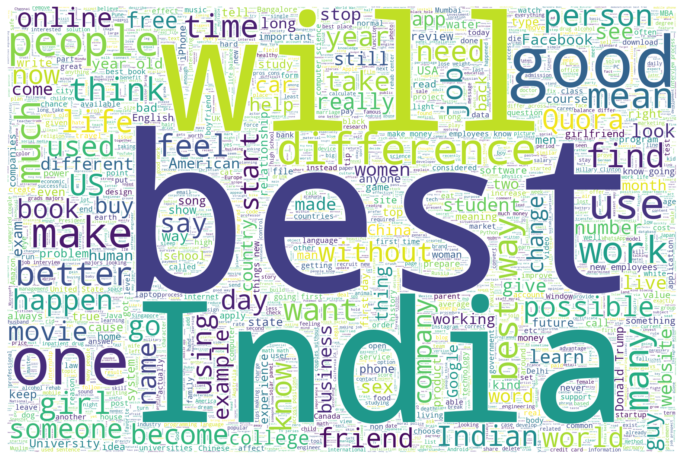

In [63]:
wc = WordCloud(background_color="white",width=1800,height=1200, max_words=len(w_nonduplicate),stopwords=stopwords)
# generate word cloud
wc.generate(w_nonduplicate)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.figure(figsize=(12,16))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

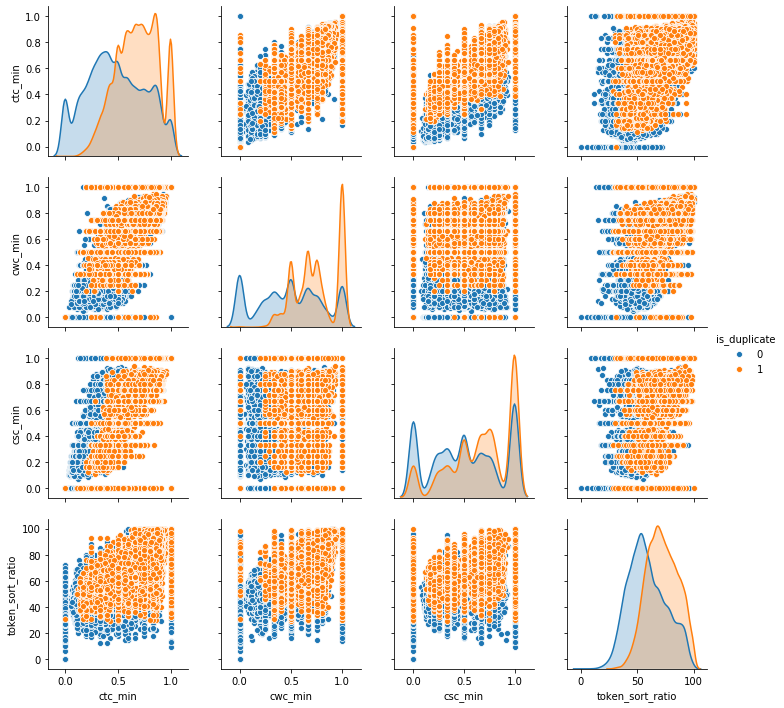

In [64]:
n = X_train_with_adv_features_eda.shape[0]
sns.pairplot(X_train_with_adv_features_eda[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n]\
             , hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()



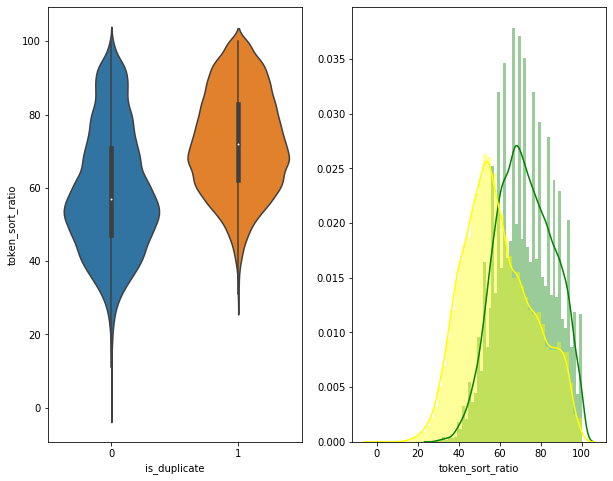

In [65]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = X_train_with_adv_features_eda[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train_with_adv_features_eda[X_train_with_adv_features_eda['is_duplicate'] == 1.0]\
                     ['token_sort_ratio'][0:] , label = "1", color = 'green')
sns.distplot(X_train_with_adv_features_eda[X_train_with_adv_features_eda['is_duplicate'] == 0.0]\
                     ['token_sort_ratio'][0:] , label = "0" , color = 'yellow' )
plt.show()

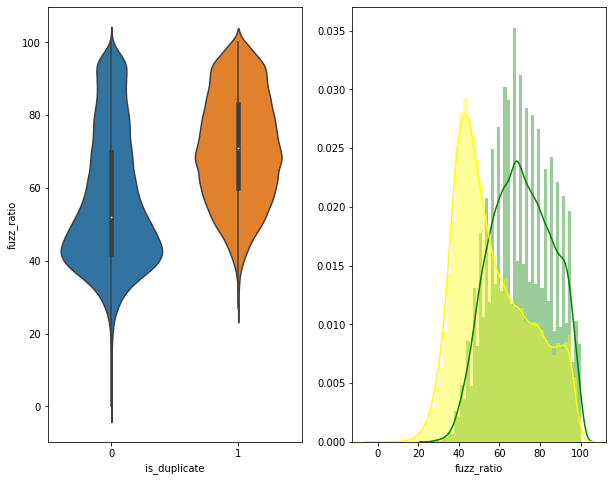

In [66]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = X_train_with_adv_features_eda[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train_with_adv_features_eda[X_train_with_adv_features_eda['is_duplicate'] == 1.0]\
             ['fuzz_ratio'][0:] , label = "1", color = 'green')
sns.distplot(X_train_with_adv_features_eda[X_train_with_adv_features_eda['is_duplicate'] == 0.0]\
             ['fuzz_ratio'][0:] , label = "0" , color = 'yellow' )
plt.show()

<h3>3.5.2 Visualization Using Tsne</h3>

In [67]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimension
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = X_train_with_adv_features_eda[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' ,\
                                'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' ,\
                                    'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , \
                                                 'longest_substr_ratio']])

y = dfp_subsampled['is_duplicate'].values

In [68]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116536
[t-SNE] Computed conditional probabilities in 0.194s
[t-SNE] Iteration 50: error = 81.4198685, gradient norm = 0.0428714 (50 iterations in 5.044s)
[t-SNE] Iteration 100: error = 70.2432785, gradient norm = 0.0103125 (50 iterations in 2.465s)
[t-SNE] Iteration 150: error = 68.2428665, gradient norm = 0.0053649 (50 iterations in 3.014s)
[t-SNE] Iteration 200: error = 67.3968735, gradient norm = 0.0039071 (50 iterations in 2.145s)
[t-SNE] Iteration 250: error = 66.8985443, gradient norm = 0.0029869

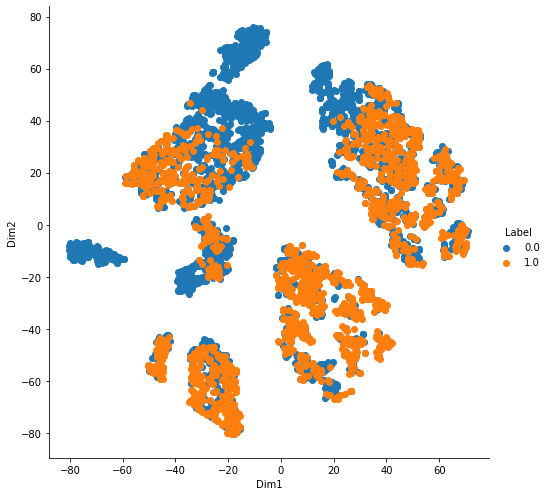

In [69]:
tsne_2d=np.vstack((tsne2d.T,y_train[:5000])).T
tsne_2d=pd.DataFrame(tsne_2d,columns=["Dim1","Dim2","Label"])
sns.FacetGrid(data=tsne_2d,hue='Label',size=7).map(plt.scatter,"Dim1","Dim2").add_legend()

<h2> 3.6 Featurizing text data with tfidf vectors </h2>

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

<h3>3.6.1. preprocessing the train data</h3>

In [71]:
train_wordvec_q["question1"] = train_wordvec_q["question1"].fillna("").apply(preprocess)
train_wordvec_q["question2"] = train_wordvec_q["question2"].fillna("").apply(preprocess)

<h3>3.6.2.using our train data vocabulary to find feature names</h3>

In [72]:
#merging all train data questions in to 1 list
questions = list(train_wordvec_q['question1']) + list(train_wordvec_q['question2'])
tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,1),max_features=2000)
tfidf.fit(questions)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_words=tfidf.get_feature_names()
print("Dimension of 1 question created after tfidf vectorization : {}".format(len(tfidf_words)))

Dimension of 1 question created after tfidf vectorization : 2000


In [73]:
def do_tfidf_vec(dataframe,data):
    
    q1_vec=tfidf.transform(dataframe["question1"].values).toarray()
    q2_vec=tfidf.transform(dataframe["question2"].values).toarray()
    
    if data=='train':
        
        pd.DataFrame(data=q1_vec,columns=tfidf_words).to_csv("train_q1_vec.csv",index=False)
        pd.DataFrame(data=q2_vec,columns=tfidf_words).to_csv("train_q2_vec.csv",index=False)
        
    if data=="test":
        
        pd.DataFrame(data=q1_vec,columns=tfidf_words).to_csv("test_q1_vec.csv",index=False)
        pd.DataFrame(data=q2_vec,columns=tfidf_words).to_csv("test_q2_vec.csv",index=False)

In [74]:
do_tfidf_vec(train_wordvec_q,"train")       

<h3>3.6.3 Concatenating the features together in final_train dataframe</h3>

In [75]:
df1=pd.read_csv("X_train_with_basic_features.csv")
df2=pd.read_csv("X_train_with_adv_features.csv")
df3=pd.read_csv("train_q1_vec.csv")
df4=pd.read_csv("train_q2_vec.csv")

#concatenating all the dataframes horizontally

final_train_df=pd.concat([df1,df2,df3,df4],axis=1)

In [76]:
pt=PrettyTable()
pt.field_names=["train dataframe type","dimensions"]
pt.add_row(["basic_featurization",df1.shape])
pt.add_row(["adv_featurization",df2.shape])
pt.add_row(["question1_vectorization",df3.shape])
pt.add_row(["question2_vectorization",df4.shape])
pt.add_row(["-------------","------------"])
pt.add_row(["final dataframe",final_train_df.shape])
print(pt)

+-------------------------+---------------+
|   train dataframe type  |   dimensions  |
+-------------------------+---------------+
|   basic_featurization   |  (70000, 11)  |
|    adv_featurization    |  (70000, 15)  |
| question1_vectorization | (70000, 2000) |
| question2_vectorization | (70000, 2000) |
|      -------------      |  ------------ |
|     final dataframe     | (70000, 4026) |
+-------------------------+---------------+


<h2>4. Applying preprocessing,feature extraction (adv/basic) on test data</h2>

<h3>4.1 null values removal  </h3>

In [77]:
X_test=null_value_replacement(X_test)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2]
Index: []

AFTER removing null values
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2]
Index: []


In [78]:
#used for basic featurization
test_bsft=X_test.copy()

X_test["question1"] = X_test["question1"].fillna("").apply(preprocess)
X_test["question2"] = X_test["question2"].fillna("").apply(preprocess)

#used for tidf vec and adv featurizations
test_advft=X_test.copy()
test_wordvec_q=X_test.copy()

<h3>4.2 basic and advance featurization of test data</h3>

In [79]:
print(datetime.datetime.now())
print("bsic featurization on progress....")
add_basic_feature(test_bsft,"test")

print("adv featurization on progress....")
extract_features(test_advft,"test")
print(datetime.datetime.now())

2019-08-22 14:45:20.710146
bsic featurization on progress....
the basic features dataframe now consists of columns Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')
adv featurization on progress....
token features...
fuzzy features..
2019-08-22 14:46:21.873186


<h3>4.3 tfidf vectorization  of test data </h3>

In [80]:
do_tfidf_vec(test_wordvec_q,"test")

<h3>4.4 combining our test dataframes so as to create final test dataframe that can be used by our ML models </h3>

In [81]:
dftest1=pd.read_csv("X_test_with_basic_features.csv")
dftest2=pd.read_csv("X_test_with_adv_features.csv")
dftest3=pd.read_csv("test_q1_vec.csv")
dftest4=pd.read_csv("test_q2_vec.csv")

#concatenating all the dataframes horizontally

final_test_df=pd.concat([dftest1,dftest2,dftest3,dftest4],axis=1)

In [82]:
pt=PrettyTable()
pt.field_names=["Test dataframe type","dimensions"]
pt.add_row(["basic_featurization",dftest1.shape])
pt.add_row(["adv_featurization",dftest2.shape])
pt.add_row(["question1_vectorization",dftest3.shape])
pt.add_row(["question2_vectorization",dftest4.shape])
pt.add_row(["-------------","------------"])
pt.add_row(["final dataframe",final_test_df.shape])
print(pt)

+-------------------------+---------------+
|   Test dataframe type   |   dimensions  |
+-------------------------+---------------+
|   basic_featurization   |  (30000, 11)  |
|    adv_featurization    |  (30000, 15)  |
| question1_vectorization | (30000, 2000) |
| question2_vectorization | (30000, 2000) |
|      -------------      |  ------------ |
|     final dataframe     | (30000, 4026) |
+-------------------------+---------------+


<h1>5. Machine Learning Models </h1>

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from sklearn.metrics import log_loss,confusion_matrix

<h3>To Plot confusion Matrix,Precision Matrix,recall Matrix</h3>

In [84]:
def conf_mtx(y_original,y_predicted):
    
    C=confusion_matrix(y_original,y_predicted)
    
    Pr_mtx=C/np.sum(C,axis=0)  
    
    Rec_mtx=C/np.sum(C,axis=1).reshape(2,1)
    
    
    plt.figure(figsize=(18,5))
    
    title=["confusion matrix","precision matrix","Recall matrix"]
    labels=[0,1]
    #vertically stacking the mtxs
    mtx1=C.flatten()
    mtx2=Pr_mtx.flatten()
    mtx3=Rec_mtx.flatten()
    
    matrices=np.vstack((mtx1,mtx2,mtx3))
    
    cmap=sns.light_palette("olive")
    for i in range(matrices.shape[0]):
        plt.subplot(1,3,i+1)
        sns.heatmap(matrices[i].reshape(2,2), annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(title[i])
    

<h3> 5.1 Building a random model (Finding worst-case log-loss) </h3>

Log-loss Of a random model achieved is 0.8871794110123485
--------------------------------------------------------------------------------------------------------------


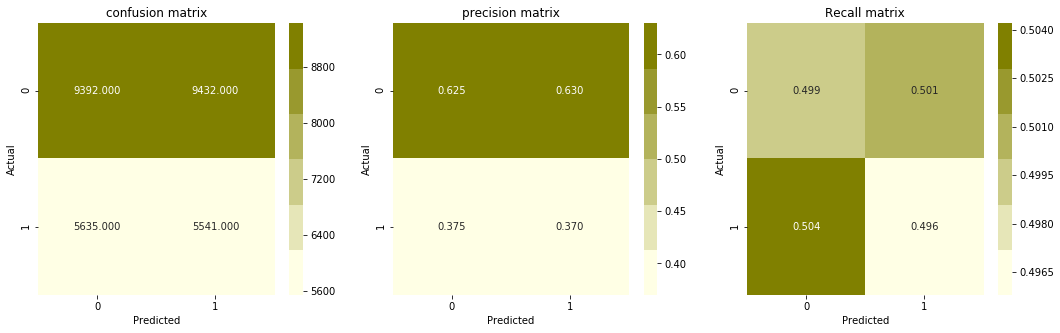

In [85]:
#we build a random model that will predict probabilities of positive and negative class
len_test=X_test.shape[0]
predicted_y_random=np.zeros((len_test,2))  #as it is binary class classification


for i in range(len_test):
    prob_scores=np.random.rand(1,2)
    prob_scores=prob_scores/np.sum(prob_scores,axis=1)
    predicted_y_random[i]=prob_scores

print("Log-loss Of a random model achieved is {}".format(log_loss(y_test,predicted_y_random[:,1])))
print("-"*110)


test_logloss_rd=log_loss(y_test,predicted_y_random[:,1])

y_pred=np.argmax(predicted_y_random,axis=1)
conf_mtx(y_test,y_pred)

<h3>5.2 Logistic Regression with hyperparameter tuning(sgdclassifier with loss='log' )</h3>

<h4>5.2.1 hyperparameter tuning to get the best hyperparameter</h4>

In [86]:
#k-fold cross validation:
#this same dataset is usd for svm
train1,taraincv,label1,labelcv=train_test_split(final_train_df,y_train,test_size=0.2)
print("size of cross validation data {}".format(taraincv.shape) )

size of cross validation data (14000, 4026)


for alpha 1e-05 we get a log loss of 0.47249523553135153 in cv data
for alpha 0.0001 we get a log loss of 0.48768689145722405 in cv data
for alpha 0.001 we get a log loss of 0.4917043881250064 in cv data
for alpha 0.01 we get a log loss of 0.4756039247878479 in cv data
for alpha 0.1 we get a log loss of 0.4972692978525782 in cv data
for alpha 1 we get a log loss of 0.5342492443330756 in cv data
for alpha 10 we get a log loss of 0.5766096385577134 in cv data


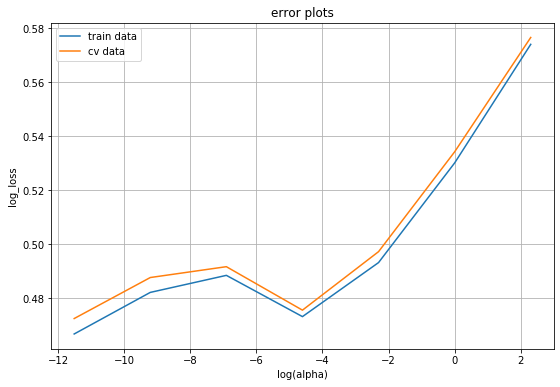

In [87]:
alphas=[10**x for x in range(-5,2)]
log_loss_list_cv=[]
log_loss_list_train=[]
for i in alphas:
    sgdc=SGDClassifier(alpha=i,penalty='l2',class_weight='balanced',loss='log',fit_intercept=True)
    sgdc.fit(train1,label1)
    clb_clf1=CalibratedClassifierCV(base_estimator=sgdc,method='isotonic')
    clb_clf1.fit(train1,label1)
    pred_train=clb_clf1.predict_proba(train1)[:,1]
    pred_cv=clb_clf1.predict_proba(taraincv)[:,1]
    
    log_loss_list_train.append(log_loss(label1,pred_train))
    log_loss_list_cv.append(log_loss(labelcv,pred_cv)) 
    print("for alpha {} we get a log loss of {} in cv data".format(i,log_loss(labelcv,pred_cv)))
    
#plotting the graph of log_loss vs hyperparameter
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(np.log(alphas),log_loss_list_train,label="train data")
plt.plot(np.log(alphas),log_loss_list_cv,label="cv data")
plt.xlabel("log(alpha)")
plt.ylabel("log_loss")
plt.title("error plots")
plt.legend()

<h4>5.2.2 using best hyperparameter</h4>

log-loss on the test data is 0.5126920291550449


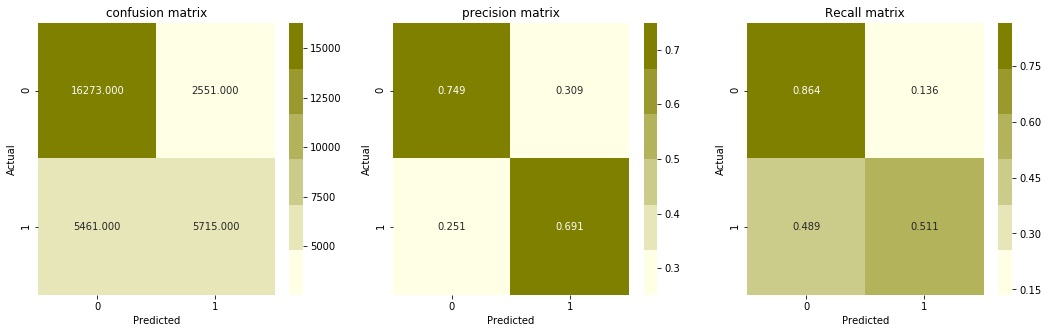

In [88]:
idx=np.argmin(log_loss_list_cv)
best_alpha_lr=alphas[idx]

sgdc=SGDClassifier(alpha=alphas[idx],loss='log',penalty='l2',class_weight='balanced',fit_intercept=True)
sgdc.fit(final_train_df,y_train)

clb_clf=CalibratedClassifierCV(base_estimator=sgdc,method='isotonic')
clb_clf.fit(final_train_df,y_train)

test_pred_prob=clb_clf.predict_proba(final_test_df)[:,1]

print("log-loss on the test data is {}".format(log_loss(y_test,test_pred_prob)))

predict_y=np.argmax(clb_clf.predict_proba(final_test_df),axis=1)
conf_mtx(y_test,predict_y)

tr_logloss_lr=log_loss(y_train,clb_clf.predict_proba(final_train_df)[:,1])
test_logloss_lr=log_loss(y_test,clb_clf.predict_proba(final_test_df)[:,1])

<h3>5.3 Linear SVM with hyperparameter tuning(sgdclassifier with loss='hinge' )</h3>

<h4>5.3.1 hyperparameter tuning to get the best hyperparameter</h4>

for alpha 1e-05 we get a log loss of 0.4755805267945142 in cv data
for alpha 0.0001 we get a log loss of 0.4853535517669499 in cv data
for alpha 0.001 we get a log loss of 0.4869230558040654 in cv data
for alpha 0.01 we get a log loss of 0.46751730910850037 in cv data
for alpha 0.1 we get a log loss of 0.49886626488718916 in cv data
for alpha 1 we get a log loss of 0.5321195132315003 in cv data
for alpha 10 we get a log loss of 0.5629181207846591 in cv data


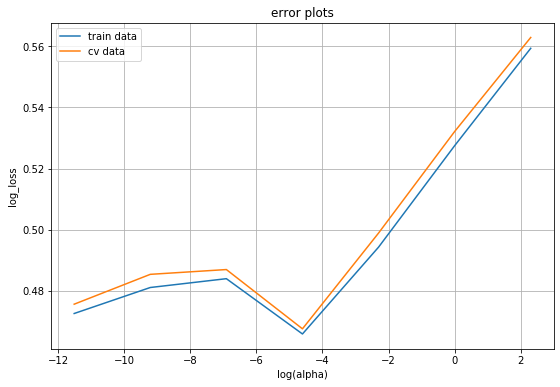

In [89]:
log_loss_list_cv=[]
log_loss_list_train=[]
for i in alphas:
    sgdc=SGDClassifier(alpha=i,penalty='l2',class_weight='balanced',loss='hinge',fit_intercept=True)
    sgdc.fit(train1,label1)
    clb_clf1=CalibratedClassifierCV(base_estimator=sgdc,method='isotonic')
    clb_clf1.fit(train1,label1)
    pred_train=clb_clf1.predict_proba(train1)[:,1]
    pred_cv=clb_clf1.predict_proba(taraincv)[:,1]
    
    log_loss_list_train.append(log_loss(label1,pred_train))
    log_loss_list_cv.append(log_loss(labelcv,pred_cv)) 
    print("for alpha {} we get a log loss of {} in cv data".format(i,log_loss(labelcv,pred_cv)))
    
#plotting the graph of log_loss vs hyperparameter
plt.figure(figsize=(9,6))
plt.grid()
plt.plot(np.log(alphas),log_loss_list_train,label="train data")
plt.plot(np.log(alphas),log_loss_list_cv,label="cv data")
plt.xlabel("log(alpha)")
plt.ylabel("log_loss")
plt.title("error plots")
plt.legend()

<h4>5.3.2 using best hyperparameter</h4>

log-loss on the test data is 0.5064364212928926


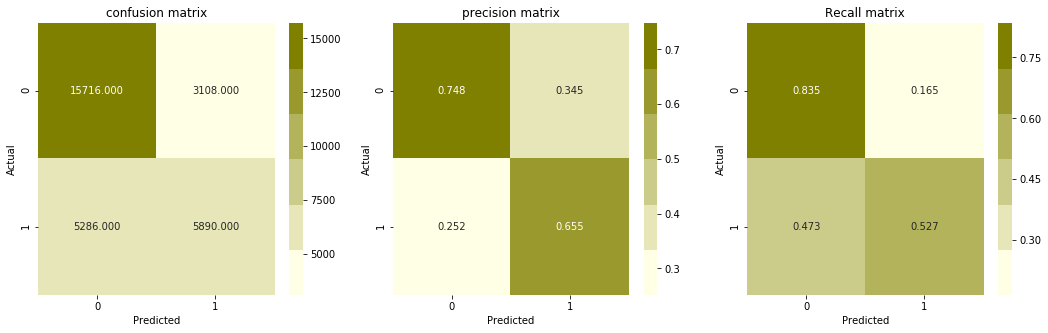

In [90]:
idx=np.argmin(log_loss_list_cv)
sgdc=SGDClassifier(alpha=alphas[idx],loss='hinge',penalty='l2',class_weight='balanced',fit_intercept=True)
sgdc.fit(final_train_df,y_train)
best_alpha_svc=alphas[idx]

clb_clf=CalibratedClassifierCV(base_estimator=sgdc,method='isotonic')
clb_clf.fit(final_train_df,y_train)

test_pred_prob=clb_clf.predict_proba(final_test_df)[:,1]

print("log-loss on the test data is {}".format(log_loss(y_test,test_pred_prob)))

predict_y=np.argmax(clb_clf.predict_proba(final_test_df),axis=1)
conf_mtx(y_test,predict_y)

tr_logloss_svc=log_loss(y_train,clb_clf.predict_proba(final_train_df)[:,1])
test_logloss_svc=log_loss(y_test,clb_clf.predict_proba(final_test_df)[:,1])

<h3>5.4 XGBOOST (40k train points and 10k test points)</h3>

<h4>5.4.1 tfidf-avgw2v vectorization of train data</h4>

In [186]:
#we need to have a preprocessed dataframe of questions

import spacy
nlp=spacy.load('en_core_web_sm')

question_xgb=train_wordvec_q['question1'].tolist()+train_wordvec_q['question2'].tolist()

tfidf_xgb=TfidfVectorizer(lowercase=True,use_idf=True,ngram_range=(1,2))
tfidf_xgb.fit(question_xgb)
idf_values=dict(zip(tfidf_xgb.get_feature_names(),tfidf_xgb.idf_))


In [261]:
#using list(train_wordvec_q['question1']) will use indexes of the series but as i have splitted data randomly
#so i have to use train_wordvec_q['question1'].values instead
from tqdm import tqdm_notebook as tqdm
vecs1=[]
for qu1 in tqdm(train_wordvec_q['question1'].values):
    #creating tokens of the preprocessed question
    doc1=nlp(qu1.strip())
    #defining a matrix [no_tokens x dimension for each token]
    if len(doc1)!=0:
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = idf_values[str(word1)]
            except:
                idf = 0
        
            #we are adding the token vector to complete matrix 
            #suppose we have 2 words w1,w2
            #after completion of inner loop  matrix look like wij denotes ith word with jth dimension*idf of that word
            #[[w11+w21,w12+w22.....],
            # [w11+w21,w12+w22,....]]
        
            mean_vec1 += vec1 * idf
        
        mean_vec1 = mean_vec1.mean(axis=0)
    
        vecs1.append(mean_vec1)
    # if question is an empty question we append a vector of 96 dimensions for it's w2v representation
    else:
        vecs1.append(np.zeros(96))
       

In [264]:
vecs2 = []

for qu2 in tqdm(train_wordvec_q['question2'].values):
     #creating tokens of the preprocessed question
    doc1=nlp(qu2)
    
    if len(doc1)!=0:
        #defining a matrix [no_tokens x dimension for each token]
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch idf score
            try:
                idf = idf_values[str(word1)]
            except:
                idf = 0
        
        #we are adding the token vector to complete matrix 
        #suppose we have 2 words w1,w2
        #after completion of inner loop  matrix look like wij denotes ith word with jth dimension*idf of that word
        #[[w11+w21,w12+w22.....],
        # [w11+w21,w12+w22,....]]
        
            mean_vec1 += vec1 * idf
        
        mean_vec1 = mean_vec1.mean(axis=0)
    
        vecs2.append(mean_vec1)
    else :
        vecs2.append(np.zeros(96))

In [270]:
print("after tfidf-avgw2v the train data question1 feature has shape {} x {}".format(len(vecs1),len(vecs1[0])))
print("after tfidf-avgw2v the train data question2 feature has shape {} x {}".format(len(vecs2),len(vecs2[0])))

after tfidf-avgw2v the train data question1 feature has shape 70000 x 96
after tfidf-avgw2v the train data question2 feature has shape 70000 x 96


<h4>5.4.2 Vectorizing the test data</h4>

In [276]:
#we need a preprocessed dataframe 
vecs3=[]
for qu1 in tqdm(test_wordvec_q['question1'].values):
    #creating tokens of the preprocessed question
    doc1=nlp(qu1.strip())
    #defining a matrix [no_tokens x dimension for each token]
    if len(doc1)!=0:
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = idf_values[str(word1)]
            except:
                idf = 0
        
            #we are adding the token vector to complete matrix 
            #suppose we have 2 words w1,w2
            #after completion of inner loop  matrix look like wij denotes ith word with jth dimension*idf of that word
            #[[w11+w21,w12+w22.....],
            # [w11+w21,w12+w22,....]]
        
            mean_vec1 += vec1 * idf
        
        mean_vec1 = mean_vec1.mean(axis=0)
    
        vecs3.append(mean_vec1)
    # if question is an empty question we append a vector of 96 dimensions for it's w2v representation
    else:
        vecs3.append(np.zeros(96))
        
       

In [277]:
vecs4=[]
for qu2 in tqdm(test_wordvec_q['question2'].values):
    #creating tokens of the preprocessed question
    doc1=nlp(qu2.strip())
    #defining a matrix [no_tokens x dimension for each token]
    if len(doc1)!=0:
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = idf_values[str(word1)]
            except:
                idf = 0
        
            #we are adding the token vector to complete matrix 
            #suppose we have 2 words w1,w2
            #after completion of inner loop  matrix look like wij denotes ith word with jth dimension*idf of that word
            #[[w11+w21,w12+w22.....],
            # [w11+w21,w12+w22,....]]
        
            mean_vec1 += vec1 * idf
        
        mean_vec1 = mean_vec1.mean(axis=0)
    
        vecs4.append(mean_vec1)
    # if question is an empty question we append a vector of 96 dimensions for it's w2v representation
    else:
        vecs4.append(np.zeros(96))
        

In [299]:
train_q1_tfidfavgw2v=pd.DataFrame(np.array(vecs1),columns=[i for i in range(96)])
train_q2_tfidfavgw2v=pd.DataFrame(np.array(vecs2),columns=[i for i in range(96,192)])
test_q1_tfidfavgw2v=pd.DataFrame(np.array(vecs3),columns=[i for i in range(96)])
test_q2_tfidfavgw2v=pd.DataFrame(np.array(vecs4),columns=[i for i in range(96,192)])

train_q2_tfidfavgw2v.head(3)

,96,97,98,99,100,101,102,103,104,105,...,182,183,184,185,186,187,188,189,190,191
0,40.562610,-47.557889,-18.064937,-69.322548,-30.787404,-12.909162,-4.802390,16.376625,-33.413604,39.327411,...,25.180605,-7.414683,30.102242,28.348434,-0.380127,35.710128,20.728055,-5.555354,-20.562672,19.372395
1,95.668008,45.442590,-113.302039,-119.671751,-49.652361,103.617294,179.030601,13.994713,-30.931700,68.624036,...,97.838295,-22.258203,109.942595,18.353546,30.655160,-34.873656,26.201014,109.826783,-90.083832,10.521070
2,34.768775,-32.140548,38.099483,-96.399760,-89.067838,77.631863,21.391238,72.872371,-38.168850,69.891547,...,91.518553,-21.336288,64.498762,37.679497,-32.072660,-14.350817,33.063736,-33.879841,22.388369,7.359697


<h4>5.4.3 Stacking the data with basic featues and advance features</h4>

In [293]:
dftrain1=pd.read_csv("X_train_with_basic_features.csv")
dftrain1.head(2)


,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,2,2,28,34,7,9,7.0,16.0,0.4375,4,0
1,1,4,42,70,7,13,4.0,20.0,0.2000,5,3


In [294]:
dftrain2=pd.read_csv("X_train_with_adv_features.csv")
dftrain2.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.999967,0.999967,0.999975,0.666656,0.999986,0.777769,1.0,1.0,2.0,8.0,100,90,90,79,0.517241
1,0.799984,0.571420,0.999950,0.333328,0.857131,0.461535,0.0,1.0,6.0,10.0,87,59,56,67,0.395349


In [296]:
train_for_xgb=pd.concat([dftrain1,dftrain2,train_q1_tfidfavgw2v,train_q2_tfidfavgw2v],axis=1)
train_for_xgb.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,182,183,184,185,186,187,188,189,190,191
0,2,2,28,34,7,9,7.0,16.0,0.43750,4,...,25.180605,-7.414683,30.102242,28.348434,-0.380127,35.710128,20.728055,-5.555354,-20.562672,19.372395
1,1,4,42,70,7,13,4.0,20.0,0.20000,5,...,97.838295,-22.258203,109.942595,18.353546,30.655160,-34.873656,26.201014,109.826783,-90.083832,10.521070
2,1,1,50,62,10,14,6.0,23.0,0.26087,2,...,91.518553,-21.336288,64.498762,37.679497,-32.072660,-14.350817,33.063736,-33.879841,22.388369,7.359697


<h5>Stacking for test data</h5>

In [297]:
#stacking for test data
dftest1=pd.read_csv("X_test_with_basic_features.csv")
dftest1.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,1,1,40,43,8,9,4.0,17.0,0.235294,2,0
1,1,1,61,69,12,12,9.0,24.0,0.375000,2,0


In [298]:
dftest2=pd.read_csv("X_test_with_adv_features.csv")
dftest2.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.333322,0.333322,0.599988,0.499992,0.499994,0.444440,0.0,1.0,1.0,8.5,72,59,67,68,0.317073
1,0.799984,0.666656,0.833319,0.714276,0.749994,0.749994,1.0,1.0,0.0,12.0,89,80,83,79,0.258065


In [301]:
test_for_xgb=pd.concat([dftest1,dftest2,test_q1_tfidfavgw2v,test_q2_tfidfavgw2v],axis=1)
test_for_xgb.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,182,183,184,185,186,187,188,189,190,191
0,1,1,40,43,8,9,4.0,17.0,0.235294,2,...,34.273359,9.478385,36.662726,30.802948,-16.582540,18.609194,-21.884832,40.294294,-34.627096,1.973331
1,1,1,61,69,12,12,9.0,24.0,0.375000,2,...,148.486336,11.610939,57.974067,100.394948,30.391932,11.837878,101.679450,-2.625932,-53.196994,102.396973


In [302]:
pt=PrettyTable()
pt.field_names=['data','shape']
pt.add_row(['Train data',train_for_xgb.shape])
pt.add_row(["Test Data",test_for_xgb.shape])
print(pt)

+------------+--------------+
|    data    |    shape     |
+------------+--------------+
| Train data | (70000, 218) |
| Test Data  | (30000, 218) |
+------------+--------------+


<h4>5.4.4 Selecting 40k:10k for our Xgboost model</h4>

In [304]:
xgb_train=train_for_xgb[:40000]
xgb_test=test_for_xgb[:10000]
xgb_ytrain=y_train[:40000]
xgb_ytest=y_test[:10000]

<h4>5.4.5 Training our xgboost model</h4>

In [311]:
def error_plots(grid_classifier,hyper_param):
    
    plt.figure(figsize=(16,8))
    
    data=["train","test"]
    n_esti=hyper_param['n_estimators']
    mx_dpth=hyper_param['max_depth']
    
    #creating 2 matrix for train and test data
    mtx1=np.zeros((len(n_esti),len(mx_dpth)))
    mtx2=np.zeros((len(n_esti),len(mx_dpth)))
    
    for i in range(len(grid_classifier.cv_results_['params'])):
        row_no=n_esti.index(grid_classifier.cv_results_['params'][i]['n_estimators'])
        col_no=mx_dpth.index(grid_classifier.cv_results_['params'][i]['max_depth'])
        mtx1[row_no,col_no]=grid_classifier.cv_results_['mean_train_score'][i]
        
    for i in range(len(grid_classifier.cv_results_['params'])):
        row_no=n_esti.index(grid_classifier.cv_results_['params'][i]['n_estimators'])
        col_no=mx_dpth.index(grid_classifier.cv_results_['params'][i]['max_depth'])
        mtx2[row_no,col_no]=grid_classifier.cv_results_['mean_test_score'][i]
    
    #appending both matrix in a list 
    mtx_list=[mtx1,mtx2]
    
    for j in range(2):
        ax=plt.subplot(1,2,j+1)
        sns.heatmap(mtx_list[j],ax=ax,annot=True,fmt='0.3f')
        ax.set_xlabel("max_depth")
        ax.set_ylabel("n_estimators")
        ax.xaxis.set_ticklabels(mx_dpth)
        ax.yaxis.set_ticklabels(n_esti)
        ax.set_title("for "+ data[j] +" data")
        
    plt.suptitle("error plots" )

<h4>5.4.6 hyperparameter tuning to get the best hyperparameter</h4>

In [308]:
hyper_param={'n_estimators':[10,50,100,200,300,500],'max_depth':[2,3,4,5,6,7]}
print(datetime.datetime.now())
gd_s=RandomizedSearchCV(xgb.XGBClassifier(booster='gbtree'),param_distributions=hyper_param,cv=3,\
                    scoring='neg_log_loss',return_train_score=True)
gd_s.fit(xgb_train,xgb_ytrain)
print(datetime.datetime.now())

2019-08-25 13:37:45.185116
2019-08-25 14:40:08.721093


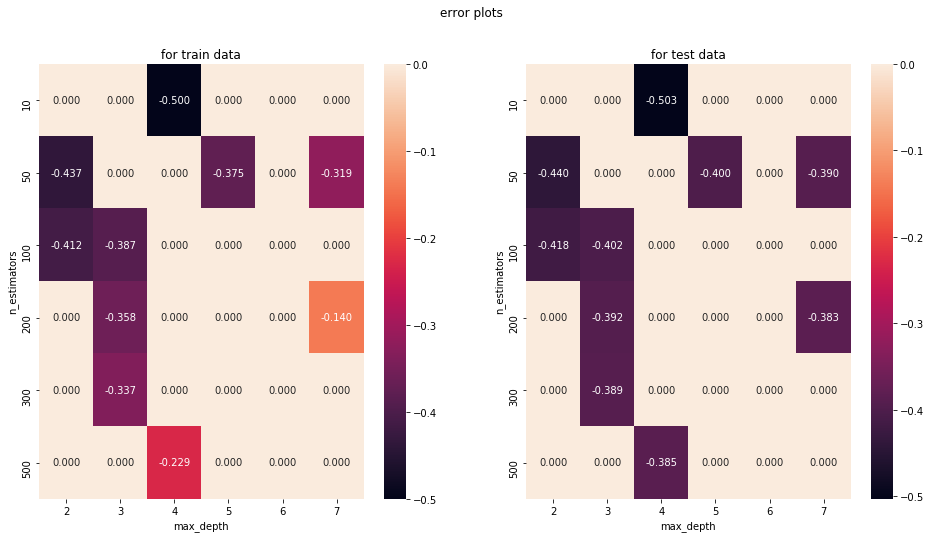

In [312]:
error_plots(gd_s,hyper_param)

<h4>5.4.2 using best hyperparameter</h4>

In [313]:
optimal_estimators=300
optimal_depth=3

In [316]:
clf_xgb=xgb.XGBClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth,booster='gbtree')
clf_xgb.fit(xgb_train,xgb_ytrain)
clb_clf=CalibratedClassifierCV(base_estimator=clf_xgb)
clb_clf.fit(xgb_train,xgb_ytrain)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=3,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=300, n_jobs=1,
                                                    nthread=None,
                                                    objective='binary:logistic',
                                                    random_state=

log-loss on the test data is 0.4302422878721242


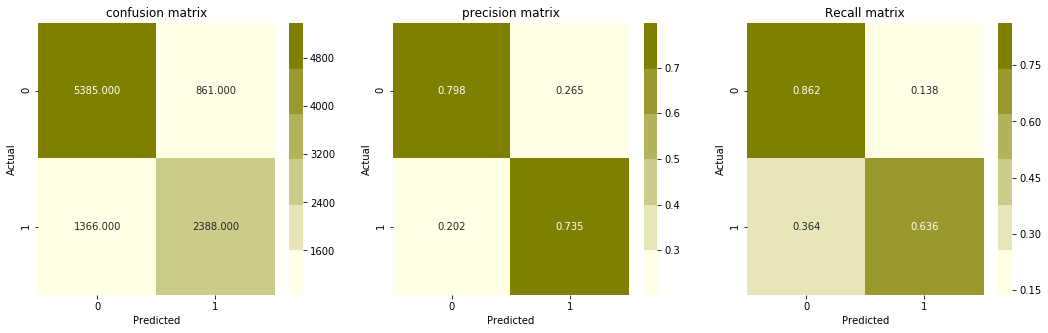

In [317]:
print("log-loss on the test data is {}".format(log_loss(xgb_ytest,clb_clf.predict_proba(xgb_test)[:,1])))

predict_y=np.argmax(clb_clf.predict_proba(xgb_test),axis=1)
conf_mtx(xgb_ytest,predict_y)

tr_logloss_xgb=log_loss(xgb_ytrain,clb_clf.predict_proba(xgb_train)[:,1])
test_logloss_xgb=log_loss(xgb_ytest,clb_clf.predict_proba(xgb_test)[:,1])


<h2>6. Conclusions</h2>

In [318]:
pt=PrettyTable()
pt.field_names=["Model","train log-loss","test log-loss","hyperparameters"]
pt.add_row(["Random model","-",test_logloss_rd,"-"])
pt.add_row(["logistic regression",tr_logloss_lr,test_logloss_lr,best_alpha_lr])
pt.add_row(["linear SVC",tr_logloss_svc,test_logloss_svc,best_alpha_svc])
pt.add_row(["Xgboost",tr_logloss_xgb,test_logloss_xgb,"estimators="+str(optimal_estimators)+", max_depth="\
            +str(optimal_depth)])
print(pt)

+---------------------+---------------------+--------------------+-----------------------------+
|        Model        |    train log-loss   |   test log-loss    |       hyperparameters       |
+---------------------+---------------------+--------------------+-----------------------------+
|     Random model    |          -          | 0.8871794110123485 |              -              |
| logistic regression | 0.47839290217335023 | 0.5126920291550449 |            1e-05            |
|      linear SVC     |  0.4747999801333193 | 0.5064364212928926 |             0.01            |
|       Xgboost       | 0.35189828749975194 | 0.4302422878721242 | estimators=300, max_depth=3 |
+---------------------+---------------------+--------------------+-----------------------------+
